In [1]:
import dice_ml
import warnings
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import DecisionBoundaryDisplay


/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [2]:
X, y = make_moons(
    n_samples=100, noise=0.2, random_state=42
)  # You can adjust the parameters as needed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
df["Target"] = y
df


,Feature1,Feature2,Target
0,1.645654,-0.536487,1
1,0.113649,0.569574,1
2,0.757790,-0.339259,1
3,-1.146562,0.231257,0
4,-0.655267,0.090329,0
...,...,...,...
95,0.177147,-0.195354,1
96,1.096075,-0.561716,1
97,0.476951,0.666176,0
98,1.873825,-0.092585,1


In [3]:
clf = SVC(gamma=1, probability=True)
clf = clf.fit(X_train, y_train)
print(" ### Accuracy:", accuracy_score(y_test, clf.predict(X_test)))


 ### Accuracy: 0.9333333333333333


In [4]:
data = dice_ml.Data(
    dataframe=df, continuous_features=["Feature1", "Feature2"], outcome_name="Target"
)
model = dice_ml.Model(model=clf, backend="sklearn")


In [5]:
explainer = dice_ml.Dice(data, model, method="random")


In [6]:
X_test[0:20]


array([[-0.97130023,  0.4427774 ],
       [ 0.23619118,  0.89304615],
       [ 0.75778982, -0.33925892],
       [ 1.39332049, -0.11720914],
       [-0.02284354, -0.09658796],
       [ 1.38425793, -0.29899479],
       [ 1.15463488, -0.31605304],
       [-0.93066564,  0.07419618],
       [ 0.81422084,  0.70377605],
       [ 0.17714748, -0.19535399],
       [-0.59821541,  0.74256985],
       [ 1.66277215, -0.13653911],
       [ 2.07607826, -0.03114839],
       [-0.67480213,  0.93993138],
       [ 1.4107341 , -0.45469221],
       [ 0.97879136,  0.84922577],
       [ 0.07396121,  0.73311427],
       [ 0.39264481,  0.15026426],
       [-0.1549164 ,  1.36984215],
       [ 0.89497257,  0.745335  ]])

In [7]:
warnings.simplefilter("ignore")
counterfactuals = explainer.generate_counterfactuals(
    query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
    total_CFs=4,
    desired_class="opposite",
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary="all",
    permitted_range=None,
    posthoc_sparsity_param=0.1,
)


100%|██████████| 2/2 [00:14<00:00,  7.33s/it]


In [8]:
counterfactuals.visualize_as_dataframe()


Query instance (original outcome : 1)


,Feature1,Feature2,Target
0,1.645654,-0.536487,1



Diverse Counterfactual set (new outcome: 0.0)


,Feature1,Feature2,Target
0,1.645654,1.355766,0
1,-0.371519,1.162981,0
2,1.067406,0.759722,0
3,0.001662,0.906126,0


Query instance (original outcome : 0)


,Feature1,Feature2,Target
0,0.113649,0.569574,0



Diverse Counterfactual set (new outcome: 1.0)


,Feature1,Feature2,Target
0,2.517661,-0.651573,1
1,0.153147,-0.637025,1
2,0.113649,0.225399,1
3,0.113649,0.092507,1


 ### Accuracy: 1.0


  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 12.98it/s]


 ### Accuracy: 1.0


100%|██████████| 2/2 [00:00<00:00, 16.16it/s]


 ### Accuracy: 0.9666666666666667


100%|██████████| 2/2 [00:00<00:00, 17.56it/s]


 ### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:00<00:00, 18.75it/s]


 ### Accuracy: 0.9


100%|██████████| 2/2 [00:00<00:00, 16.31it/s]


 ### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:00<00:00, 17.39it/s]


 ### Accuracy: 0.9


100%|██████████| 2/2 [00:00<00:00, 15.75it/s]


 ### Accuracy: 0.8666666666666667


100%|██████████| 2/2 [00:00<00:00, 14.60it/s]


 ### Accuracy: 0.9333333333333333


100%|██████████| 2/2 [00:00<00:00, 17.48it/s]


 ### Accuracy: 0.8666666666666667


100%|██████████| 2/2 [00:19<00:00,  9.63s/it]


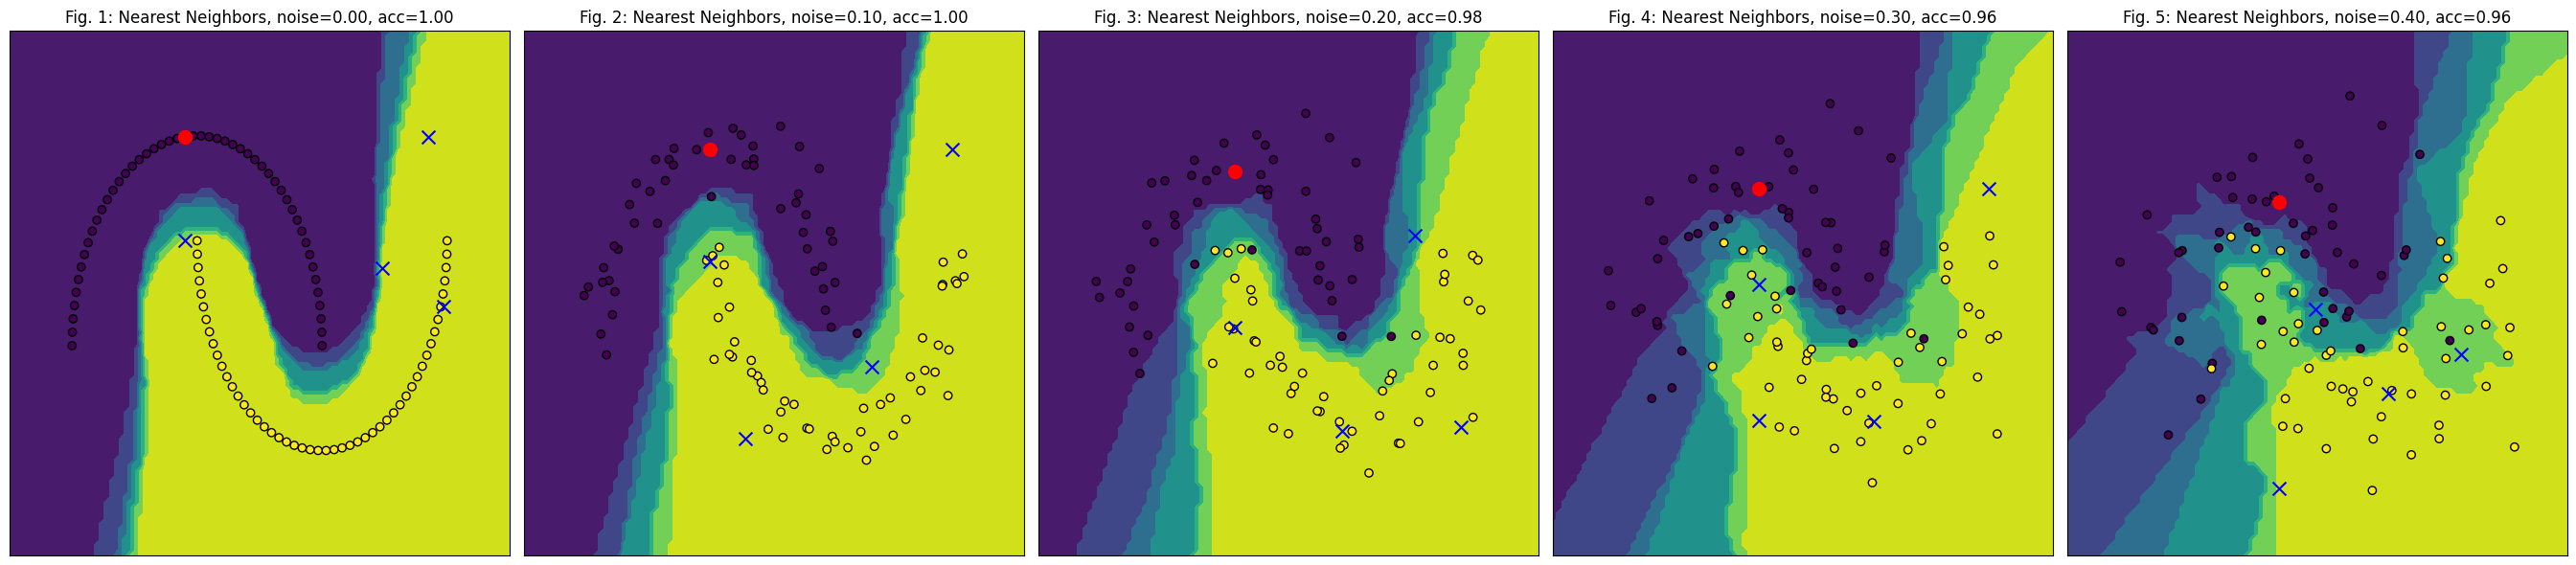

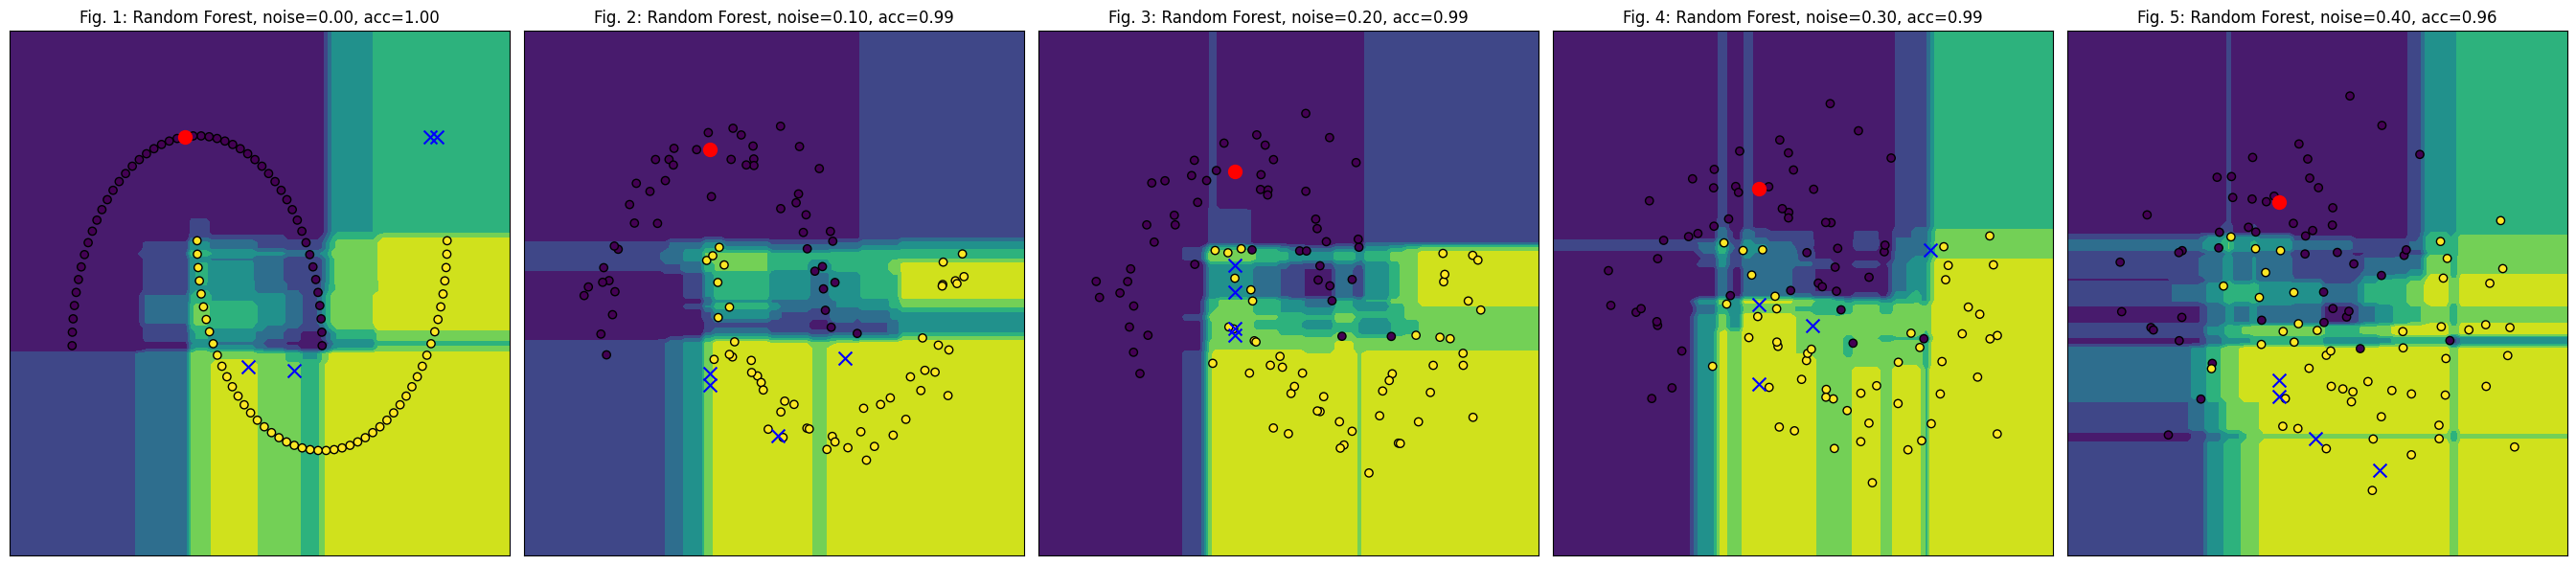

In [9]:
def visualize(
    X,
    y,
    clf,
    backend,
    n=10,
    eta=2,
    n_gs=100,
    ax=None,
):
    def plot_boundaries(X, y, ax, clf):
        """ "Plot the data and the decision boundary resulting from a classifier."""
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, eps=0.5)
        # Plot the training points
        ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=0
    )
    df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
    df["Target"] = y

    clf = clf.fit(X_train, y_train)
    print(" ### Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["Feature1", "Feature2"],
        outcome_name="Target",
    )
    model = dice_ml.Model(model=clf, backend=backend)
    if backend == "sklearn":
        explainer = dice_ml.Dice(data, model, method="random")
    else:
        explainer = dice_ml.Dice(data, model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1,
    )

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(
        df.loc[0, ["Feature1"]],
        df.loc[0, "Feature2"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)

    return ax


names = [
    "Nearest Neighbors",
    "Random Forest",
    "SVM",
]
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    # SVC(),
]

## Création de jeux de données avec différents niveaux de bruit
datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_moons(noise=noise, random_state=0))

for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
        X, y = dataset
        clf = clf.fit(X, y)
        ax = fig.add_subplot(1, len(datasets), i + 1)
        ax.set_title(
            f"Fig. {i+1}: {name}, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}"
        )
        visualize(X, y, clf, "sklearn", ax=ax)
    fig.tight_layout()


**Faire varier les paramètre de DICE**


# Pytorch


In [89]:
from typing import Any
import torch
import torch.nn as nn
import torch.optim as optim


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(2, 16)  # 2 input features, 16 hidden units
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)  # 1 output unit (binary classification)
        self.sig = nn.Sigmoid()

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        return self.forward(*args, **kwds)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sig(x)
        return x


# Generate synthetic data
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)


In [104]:
def plot_boundaries_torch(X, y, ax, model):
    """ "Plot the data and the decision boundary resulting from a classifier."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    step = 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    with torch.no_grad():
        Z = model(grid).numpy()
    Z = Z.reshape(xx.shape)

    # Plot the training points
    ax.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.8)
    # ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k")
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu, edgecolors="k")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


def train_torch_model(X_train, X_test, y_train, y_test, model):
    # Create the model
    criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy loss
    optimizer = optim.Adam(model.parameters(), lr=0.005)

    num_epochs = 2000

    for epoch in range(num_epochs):
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.float32).unsqueeze(
            1
        )  # Add a dimension for the output

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (epoch + 1) % 100 == 0:
        #     print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

    print("Training complete")

    model.eval()  # Set the model to evaluation mode
    test_inputs = torch.tensor(X_test, dtype=torch.float32)
    with torch.no_grad():
        test_outputs = model(test_inputs)
        predicted_labels = np.round(test_outputs)

    accuracy = (predicted_labels.detach().numpy() == y_test.reshape(-1, 1)).mean()
    print(f"Test Accuracy: {accuracy * 100:.2f}%")


def gen_counterfactuals(df, model):
    data = dice_ml.Data(
        dataframe=df,
        continuous_features=["Feature1", "Feature2"],
        outcome_name="Target",
    )
    dice_model = dice_ml.Model(model=model, backend="PYT")
    explainer = dice_ml.Dice(data, dice_model)

    warnings.simplefilter("ignore")
    counterfactuals = explainer.generate_counterfactuals(
        query_instances=df.loc[0:1, ["Feature1", "Feature2"]],
        total_CFs=4,
        desired_class="opposite",
        proximity_weight=0.5,
        diversity_weight=1.0,
        features_to_vary="all",
        permitted_range=None,
        posthoc_sparsity_param=0.1,
    )
    enemy_df = counterfactuals.cf_examples_list[0].final_cfs_df
    return enemy_df


def gen_data(X, y):
    df = pd.DataFrame(X, columns=["Feature1", "Feature2"])
    df["Target"] = y

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    return df, X_train, X_test, y_train, y_test


def visualizePytorch(
    X,
    y,
    model,
    ax=None,
):
    df, X_train, X_test, y_train, y_test = gen_data(X, y)
    train_torch_model(X_train, X_test, y_train, y_test, model)
    enemy_df = gen_counterfactuals(df, model)

    if not ax:
        _, ax = plt.subplots()
    plot_boundaries_torch(X, y, ax, model)
    ax.scatter(
        df.loc[0, ["Feature1"]],
        df.loc[0, "Feature2"],
        c="red",
        marker="o",
        label="Obs",
        s=100,
    )
    ax.scatter(enemy_df["Feature1"], enemy_df["Feature2"], c="blue", marker="x", s=100)
    return df, enemy_df


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 15.57it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 16.02it/s]


Training complete
Test Accuracy: 95.00%


100%|██████████| 2/2 [00:00<00:00, 15.73it/s]


Training complete
Test Accuracy: 95.00%


100%|██████████| 2/2 [00:00<00:00, 14.34it/s]


Training complete
Test Accuracy: 95.00%


100%|██████████| 2/2 [00:00<00:00, 16.56it/s]


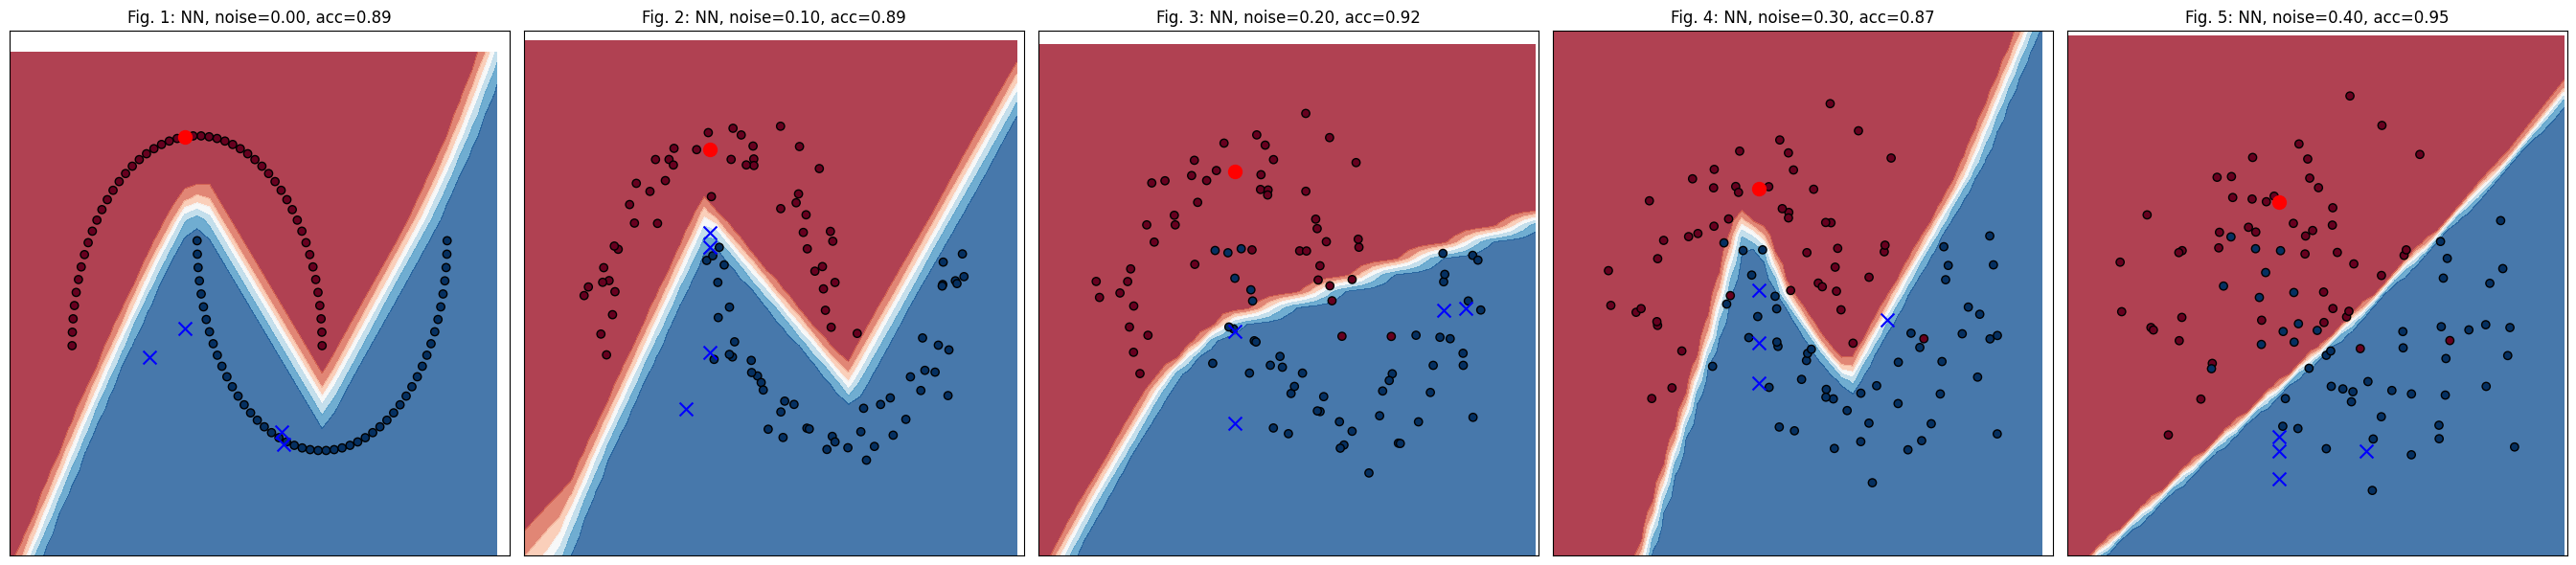

In [64]:
fig = plt.figure(figsize=(27, 6))
for i, (dataset, noise) in enumerate(zip(datasets, noise_lvl)):
    X, y = dataset
    ax = fig.add_subplot(1, len(datasets), i + 1)
    ax.set_title(
        f"Fig. {i+1}: NN, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}"
    )
    visualizePytorch(X, y, SimpleNN(), ax=ax)
fig.tight_layout()


# Validation des exemples contrefactuels générés


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:07<00:00,  3.74s/it]


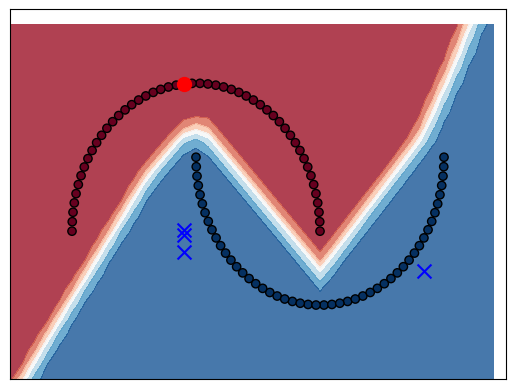

In [81]:
X, y = datasets[0]
df, enemy_df = visualizePytorch(X, y, SimpleNN())
obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
target = df.loc[0, ["Target"]]


## Validité


In [100]:
def check_validity(enemy_df: pd.DataFrame, original_target: int):
    return np.where(enemy_df["Target"].values != original_target.values, True, False)


In [101]:
check_validity(enemy_df, target)


array([ True,  True,  True,  True])

## Proximité


In [85]:
def compute_distances(enemy_df: pd.DataFrame, target: pd.DataFrame):
    """Compite

    Parameters
    ----------
    enemy_df : _type_
        _description_
    target : _type_
        _description_

    Returns
    -------
    _type_
        _description_
    """
    return np.linalg.norm(
        enemy_df.drop(columns="Target").values - target.values, axis=1
    )


In [86]:
compute_distances(enemy_df, obs_to_interprete)


array([1.13416403, 2.31211231, 1.02057702, 0.98933473])

## Parcimony


In [87]:
def mesure_parcimony(enemy_df: pd.DataFrame, target: pd.DataFrame):
    return np.linalg.norm(
        enemy_df.drop(columns="Target").values - target.values, axis=1, ord=0
    )  # non zero elemt


In [103]:
mesure_parcimony(enemy_df, obs_to_interprete)


array([1., 2., 1., 1.])

# Experiments


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:08<00:00,  4.15s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:25<00:00, 12.56s/it]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 16.00it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:00<00:00, 17.21it/s]


Training complete
Test Accuracy: 100.00%


100%|██████████| 2/2 [00:09<00:00,  4.51s/it]


([array([0.89283795, 0.76873908, 0.80568653, 0.88039682]),
  array([0.61846081, 0.98245677, 0.58946521, 0.40934732]),
  array([0.77036723, 1.5525425 , 1.0807709 , 1.47135642]),
  array([1.94696225, 1.07373816, 2.23497963, 1.90115641]),
  array([0.71657726, 0.40572333, 0.38406484, 1.04239303])],
 [array([1., 1., 1., 1.]),
  array([2., 2., 1., 2.]),
  array([2., 2., 2., 1.]),
  array([2., 2., 2., 2.]),
  array([1., 1., 1., 2.])])

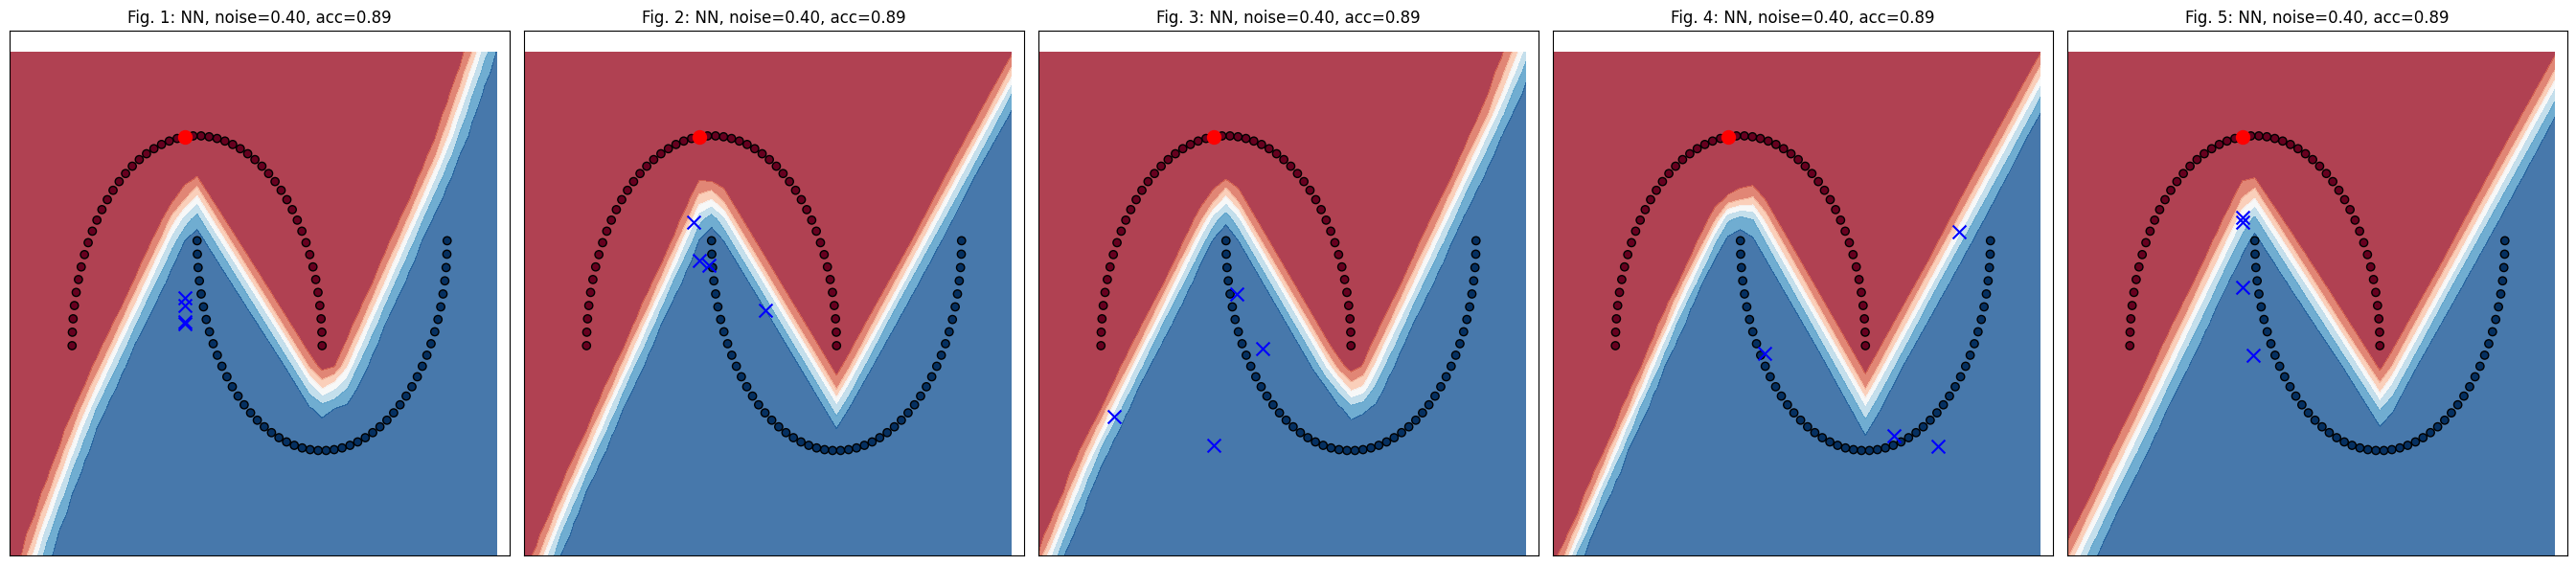

In [106]:
distance_list = []
mesure_parcimony_list = []
fig = plt.figure(figsize=(27, 6))
for i in range(5):
    X, y = datasets[0]
    ax = fig.add_subplot(1, len(datasets), i + 1)
    ax.set_title(
        f"Fig. {i+1}: NN, noise={noise:.2f}, acc={accuracy_score(y, clf.predict(X)):.2f}"
    )
    df, enemy_df = visualizePytorch(X, y, SimpleNN(), ax=ax)

    obs_to_interprete = df.loc[0, ["Feature1", "Feature2"]]
    target = df.loc[0, ["Target"]]

    valids = check_validity(enemy_df, target)
    if not valids.all():
        print("Experiment {i} : Some enemies are not valid")
        print(enemy_df)

    distance_list.append(compute_distances(enemy_df, obs_to_interprete))
    mesure_parcimony_list.append(mesure_parcimony(enemy_df, obs_to_interprete))

fig.tight_layout()
distance_list, mesure_parcimony_list
